In [1]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import sys
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from healthrex_ml.evaluators import BinaryEvaluator
from tqdm import tqdm
from functions.trainers import LightGBMTrainer

In [2]:
trainer = LightGBMTrainer(working_dir="/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts")

In [3]:
tasks = ['label_NA', 'label_K', 'label_CR', 'label_CA', 'label_ALB']

In [4]:
delta = {
    "label_NA": 2.5,
    "label_K": 0.5,
    "label_CR": 0.125,
    "label_CA": 0.525,
    "label_ALB": 0.425
}

In [5]:
for task in tasks:
    trainer(task, delta[task], True)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.572352	valid_0's binary_logloss: 0.62913
Early stopping, best iteration is:
[265]	valid_0's auc: 0.572728	valid_0's binary_logloss: 0.628907
label_NA AUC: 0.59
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.643392	valid_0's binary_logloss: 0.472636
[400]	valid_0's auc: 0.645532	valid_0's binary_logloss: 0.470959
Early stopping, best iteration is:
[363]	valid_0's auc: 0.645616	valid_0's binary_logloss: 0.470978
label_K AUC: 0.65
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.768469	valid_0's binary_logloss: 0.470268
[400]	valid_0's auc: 0.771966	valid_0's binary_logloss: 0.463621
[600]	valid_0's auc: 0.772836	valid_0's binary_logloss: 0.46208
Early stopping, best iteration is:
[568]	valid_0's auc: 0.772866	valid_0's binary_logloss: 0.462172
label_CR AUC: 0.78
Training until validation scores don't improve for 100 rounds
[200]	va

In [6]:
working_dir = "/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts"
y_hats_NA = pd.read_csv(
            os.path.join(working_dir, 'label_NA_classification_yhats.csv'))
y_hats_K = pd.read_csv(
            os.path.join(working_dir, 'label_K_classification_yhats.csv'))
y_hats_CR = pd.read_csv(
            os.path.join(working_dir, 'label_CR_classification_yhats.csv'))
y_hats_CA = pd.read_csv(
            os.path.join(working_dir, 'label_CA_classification_yhats.csv'))
y_hats_ALB = pd.read_csv(
            os.path.join(working_dir, 'label_ALB_classification_yhats.csv'))

In [7]:
y_test = pd.read_csv(
    os.path.join(working_dir, "test_labels.csv"))

In [8]:
def add_truth_label(test, delta):
    label = "label_" + test
    last_test = "label_last_" + test
    stable = "label_" + test + "_stable"
    lower = "label_" + test + "_lower"
    higher = "label_" + test + "_higher"
    y_test[lower] = (y_test[last_test] - delta > y_test[label])
    y_test[higher] = (y_test[label] > y_test[last_test] + delta)
    y_test[stable] = (~y_test[lower]) & (~y_test[higher])

In [9]:
tests = ["NA", "K", "CR", "CA", "ALB"]
d = {
    "NA": 2.5,
    "K": 0.5,
    "CR": 0.125,
    "CA": 0.525,
    "ALB": 0.425
}
for test in tests:
    add_truth_label(test, d[test])

100%|█████████████████████████████████████████████| 5/5 [02:10<00:00, 26.06s/it]


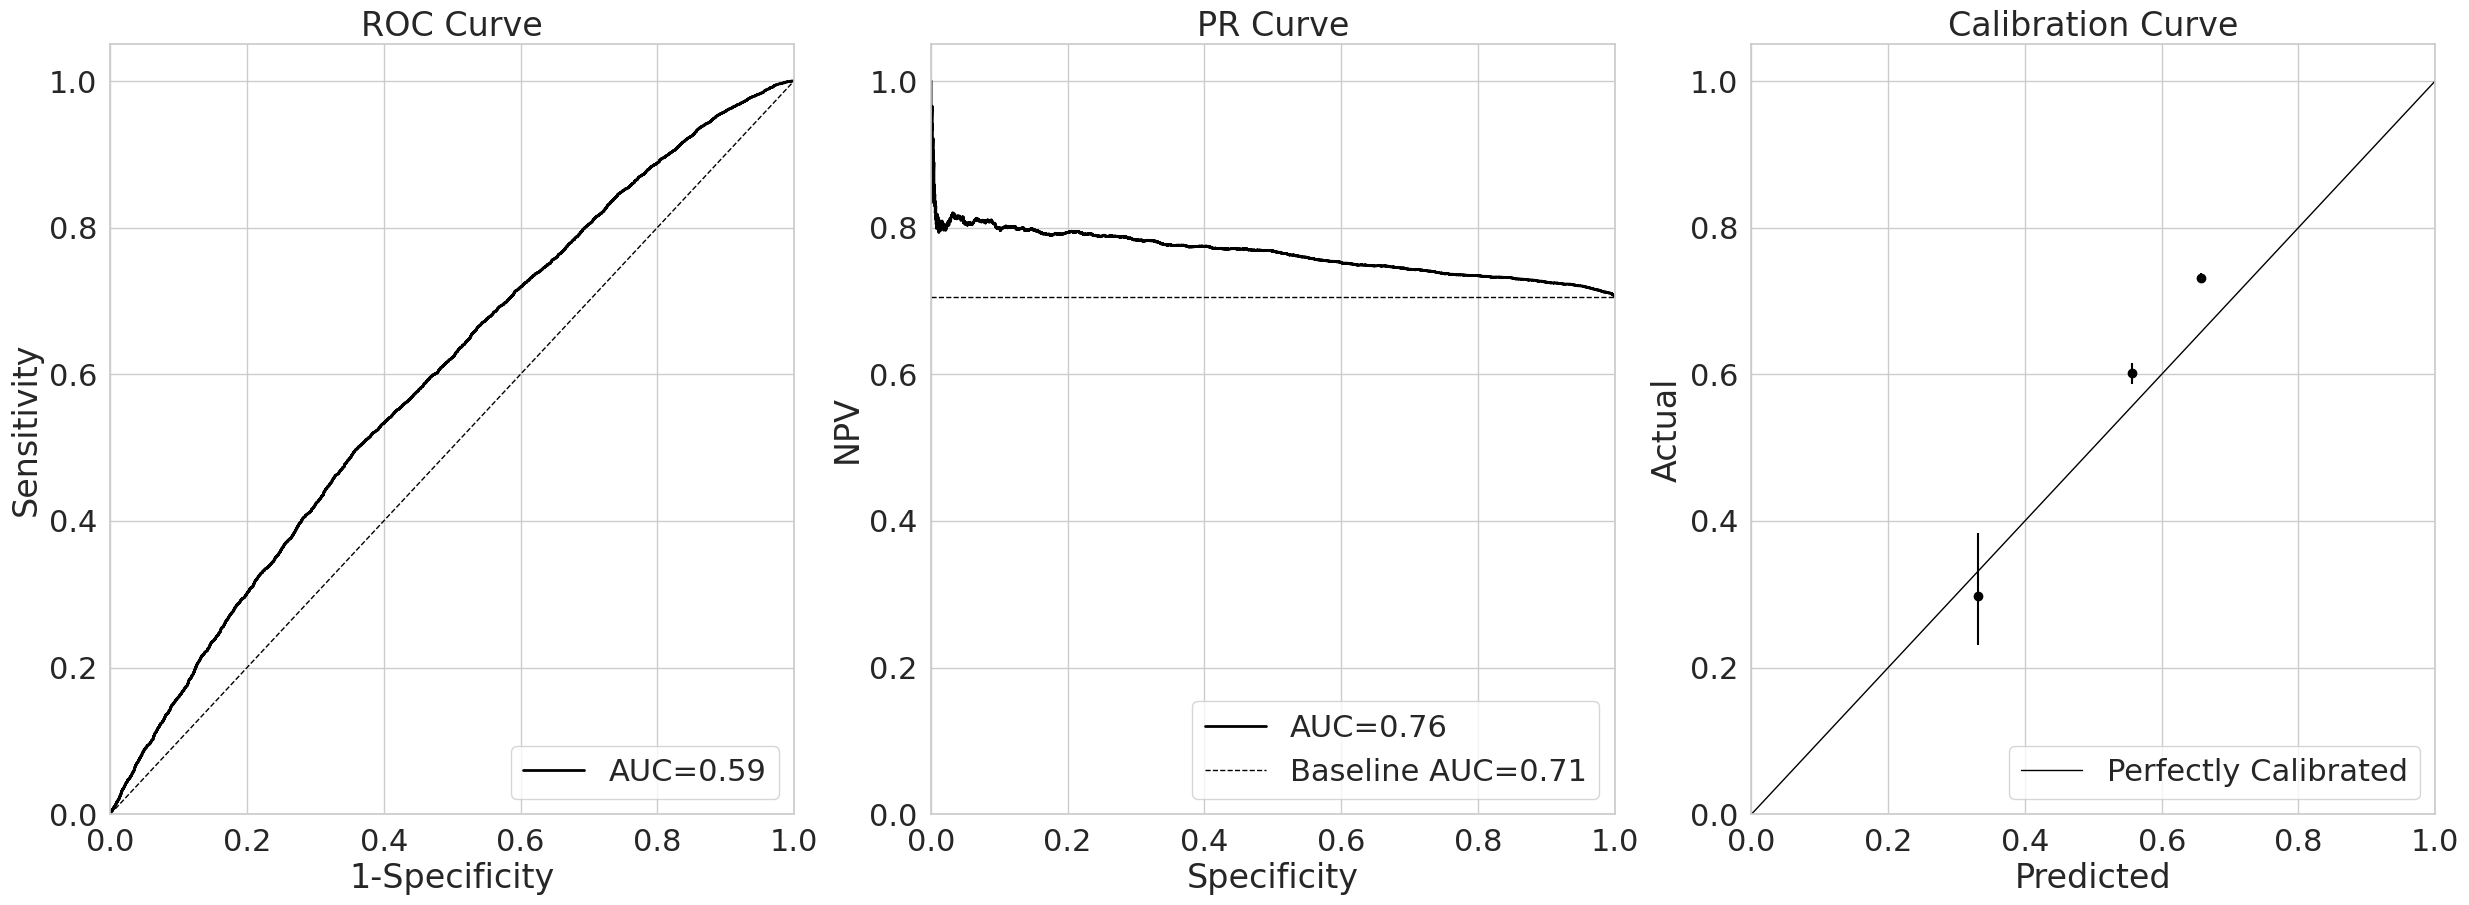

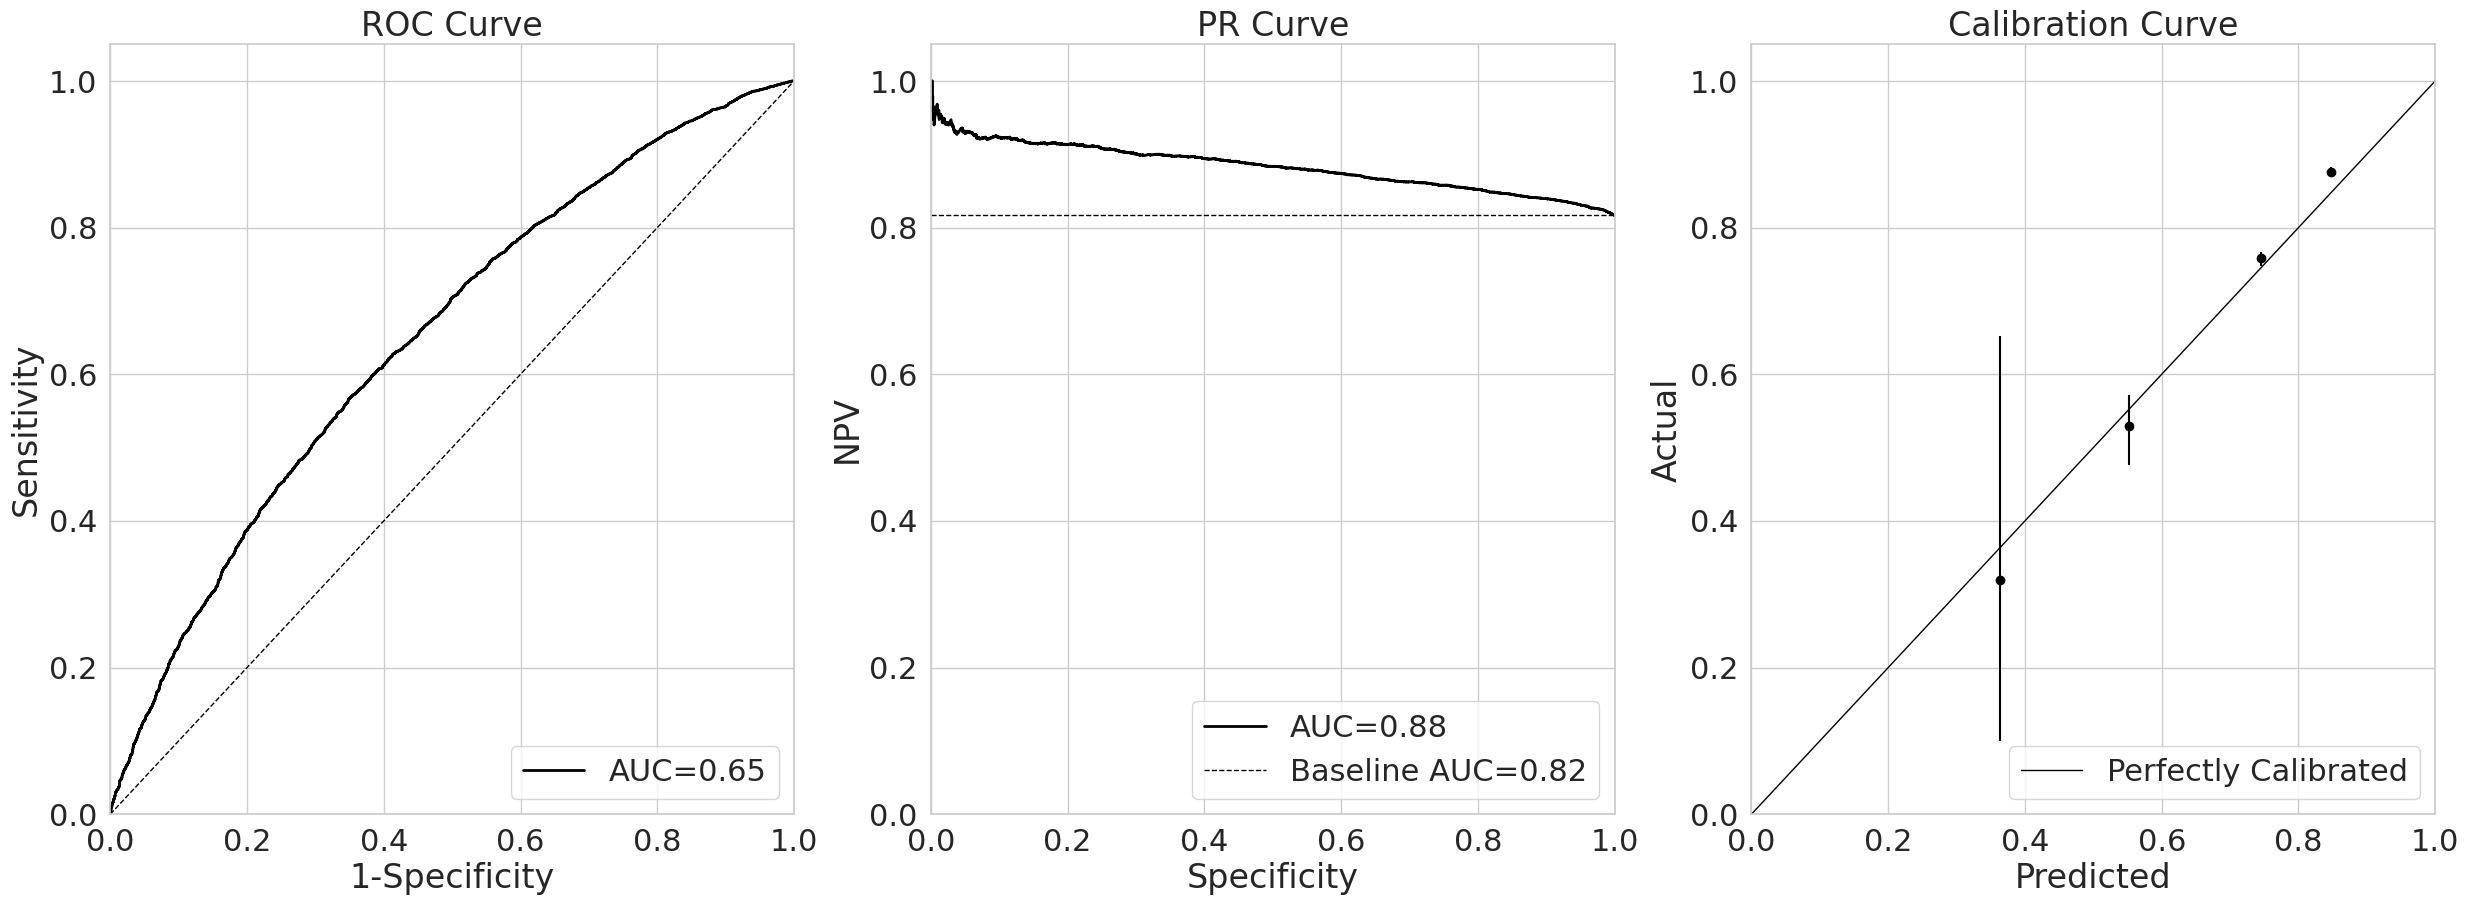

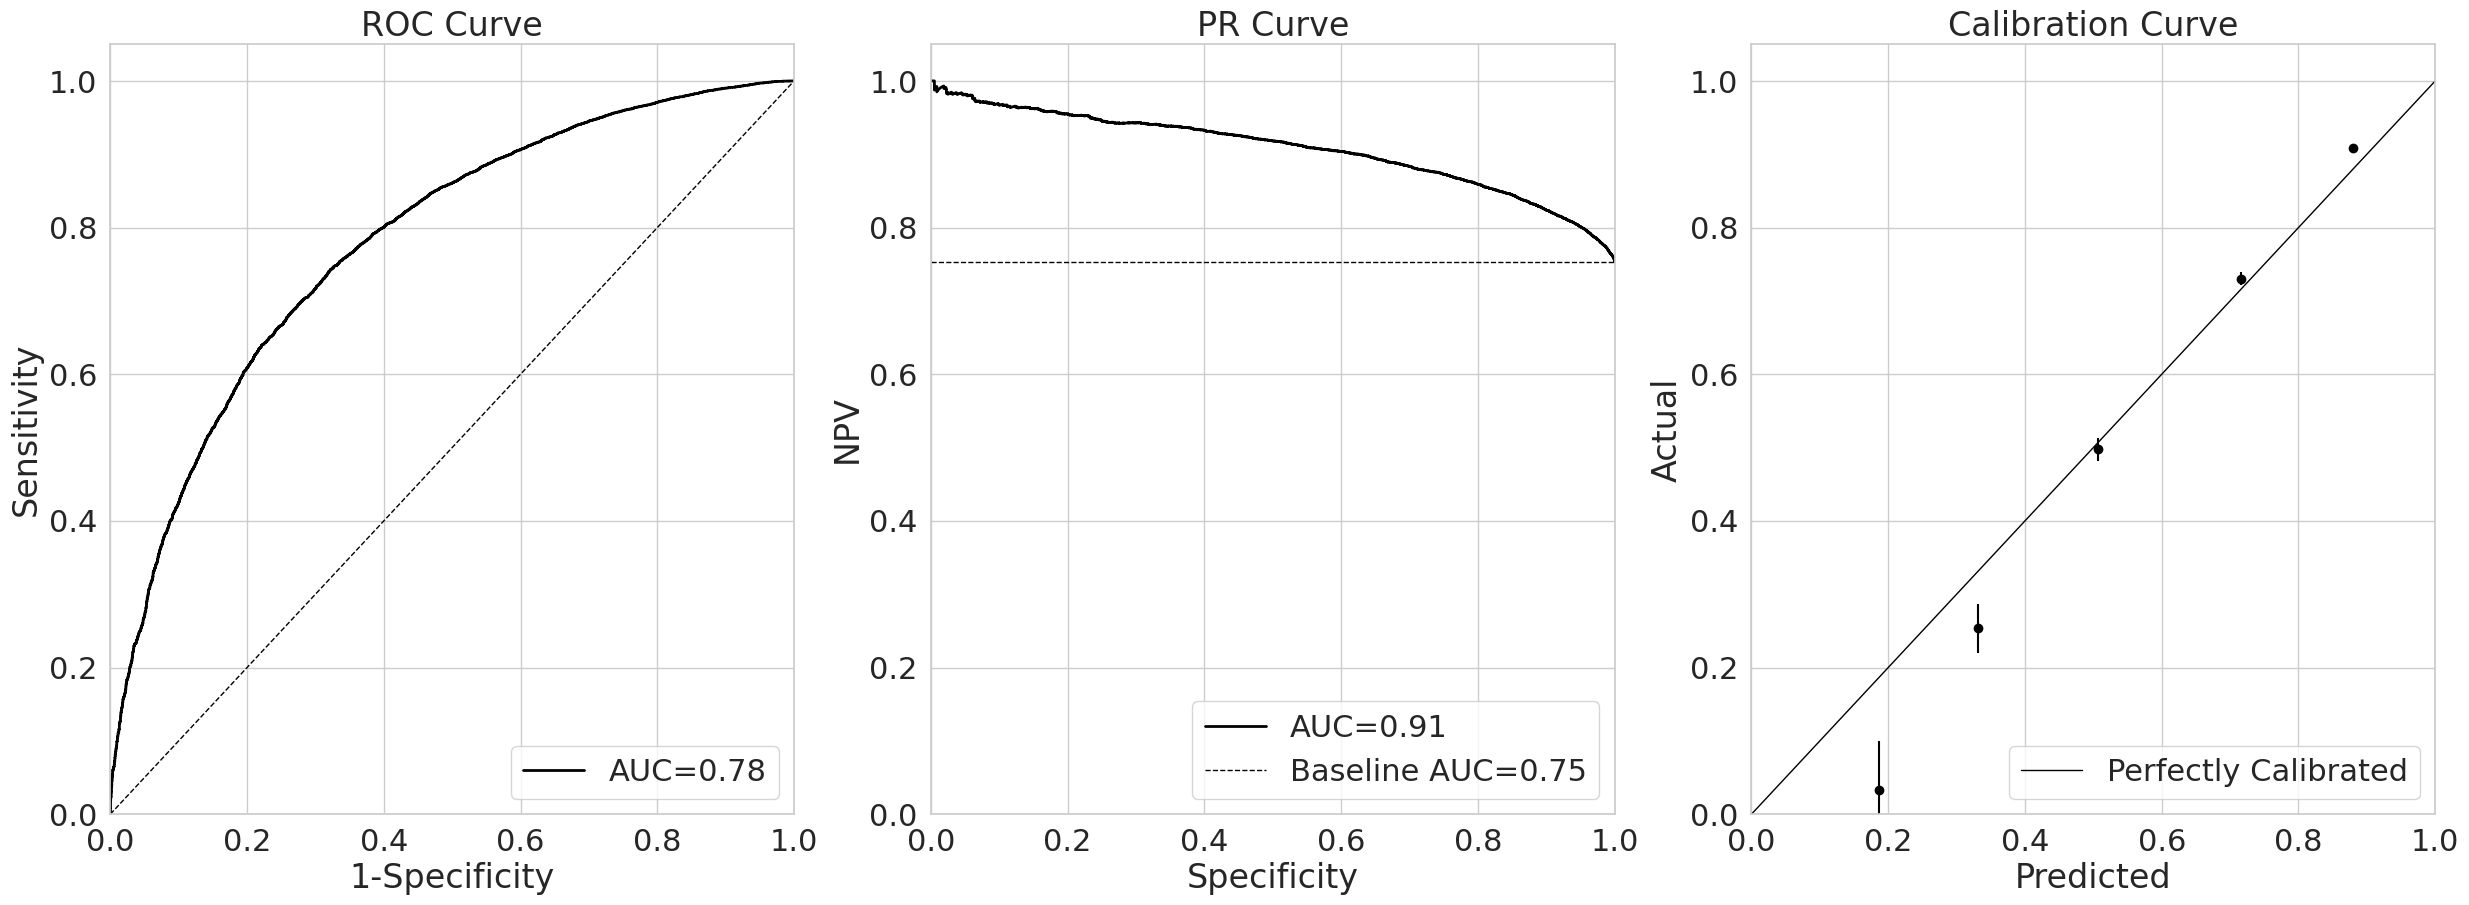

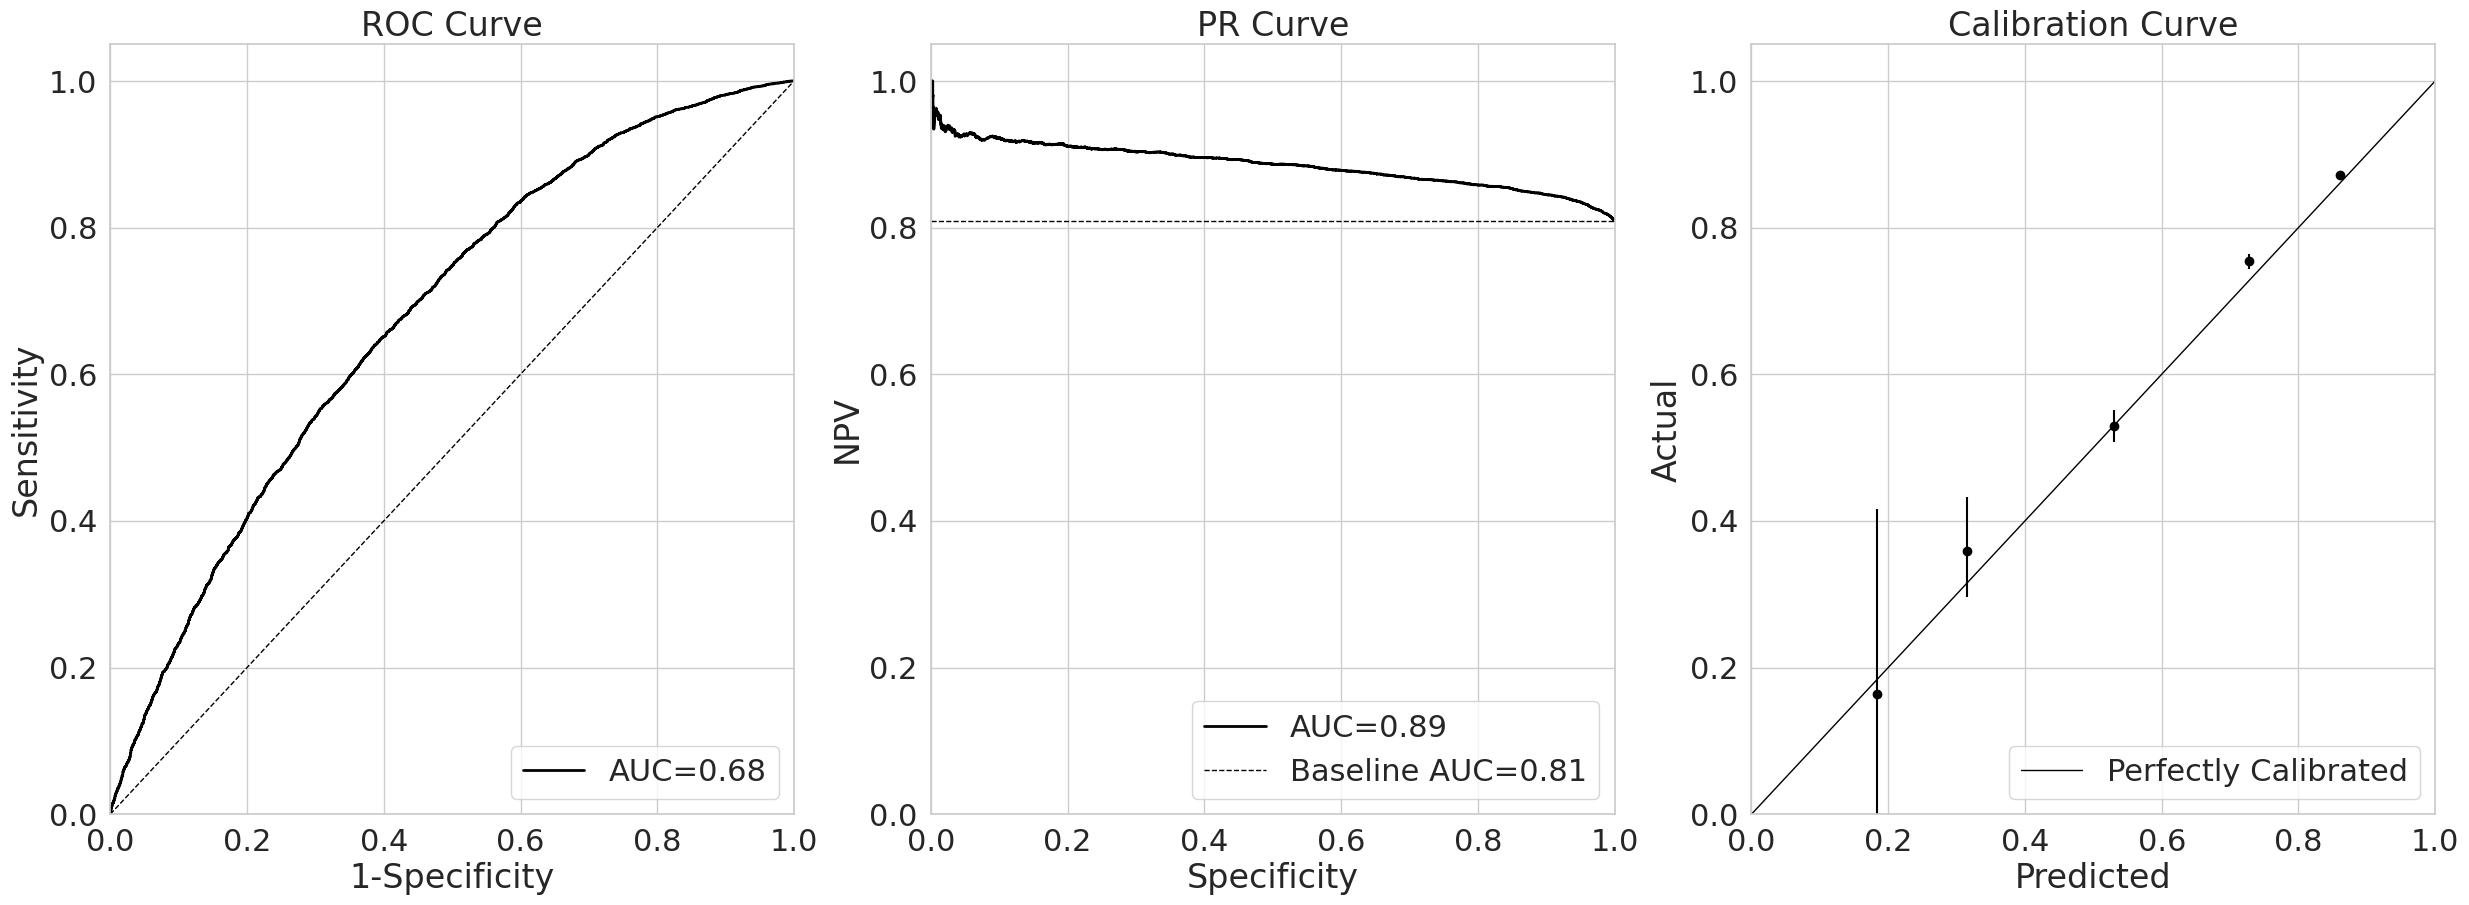

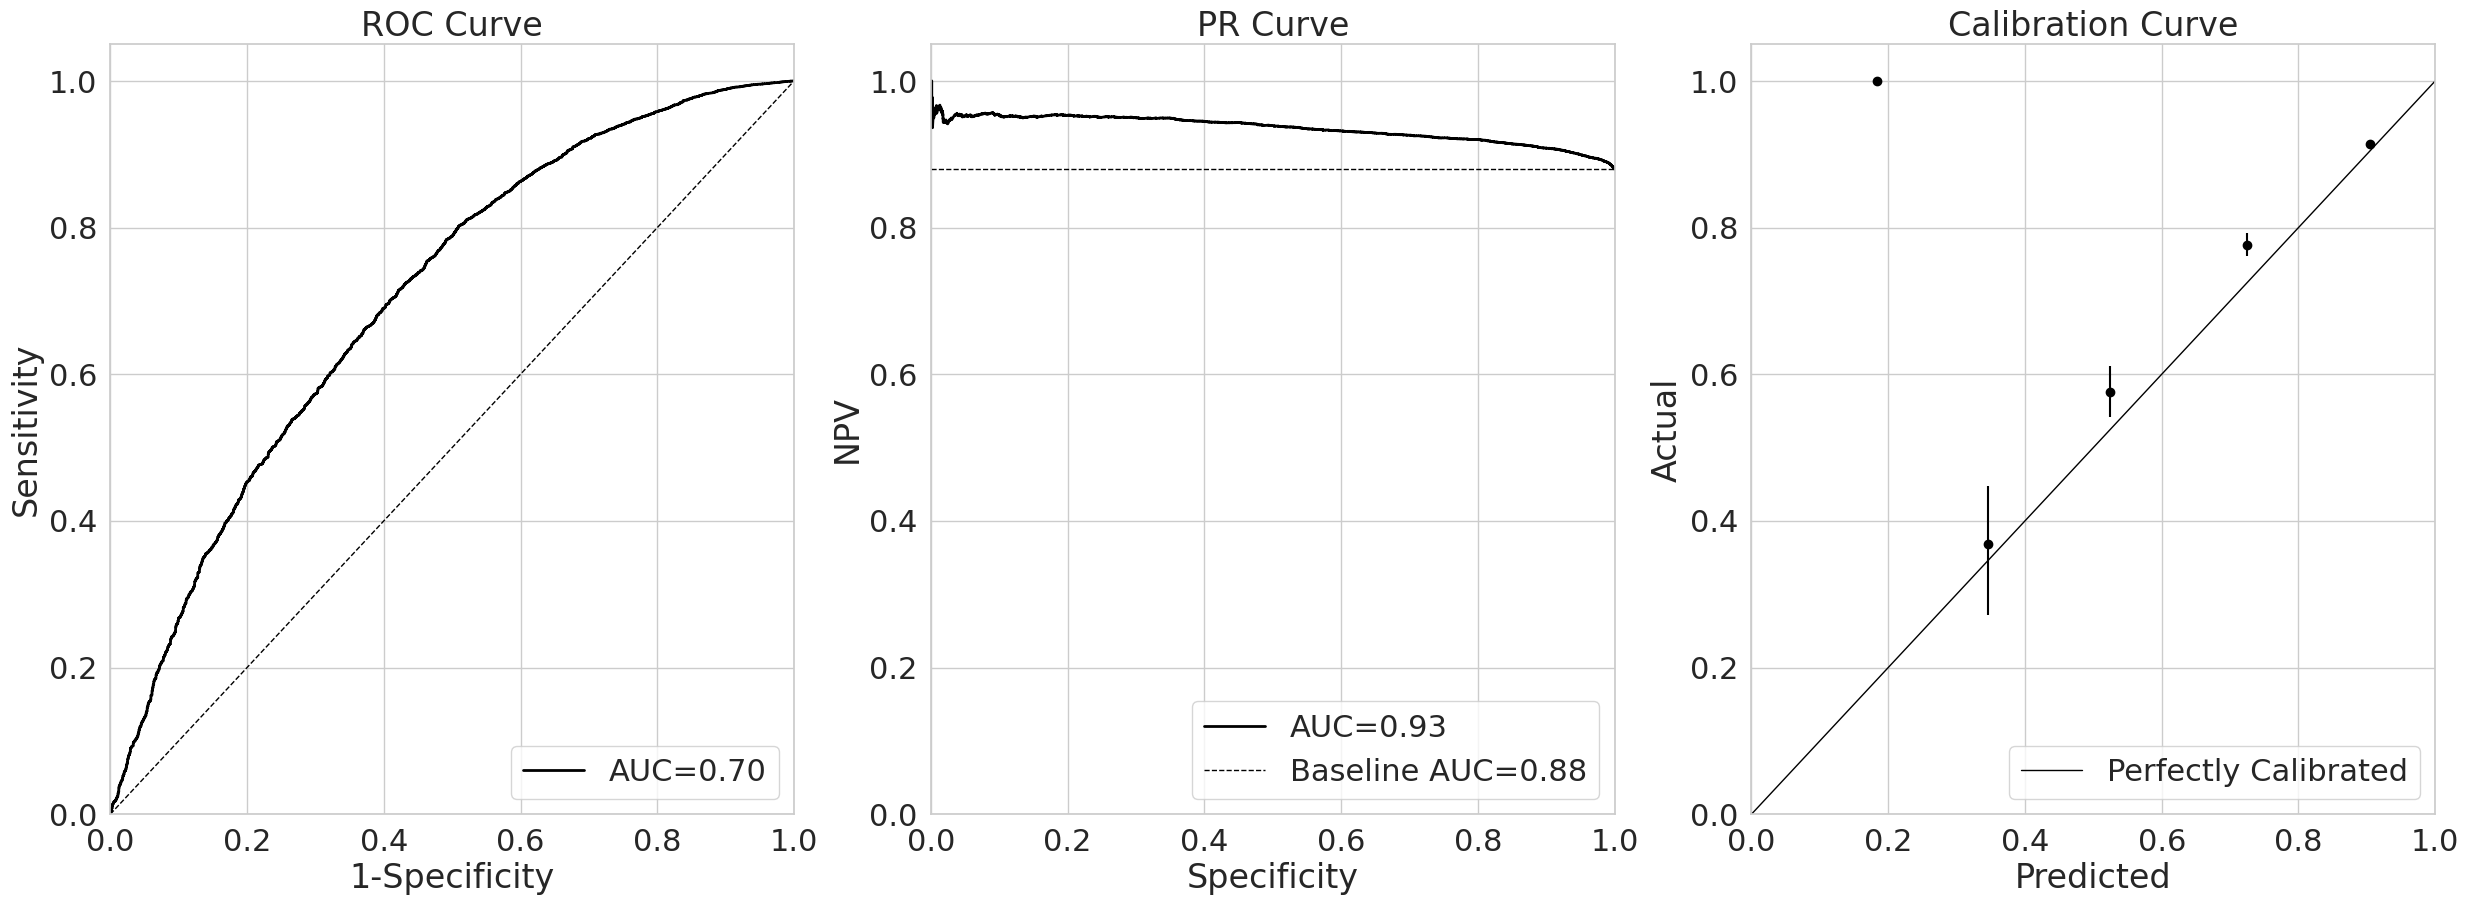

In [15]:
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir="/deep/group/aihc/win23/EHR/20230218_jyx_mcp_artifacts",
        task_name=task
    )
    key = task + "_stable"
    pred = None
    if task == "label_NA":
        pred = y_hats_NA["predictions"]
    elif task == "label_K":
        pred = y_hats_K["predictions"]
    elif task == "label_CR":
        pred = y_hats_CR["predictions"]
    elif task == "label_CA":
        pred = y_hats_CA["predictions"]
    elif task == "label_ALB":
        pred = y_hats_ALB["predictions"]
    evalr(y_test[key], pred)